In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import pandas as pd

In [3]:
df_all = pd.read_csv('/content/drive/MyDrive/urdu/th/train.csv')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3f5025cd50>,
      dtype=object)

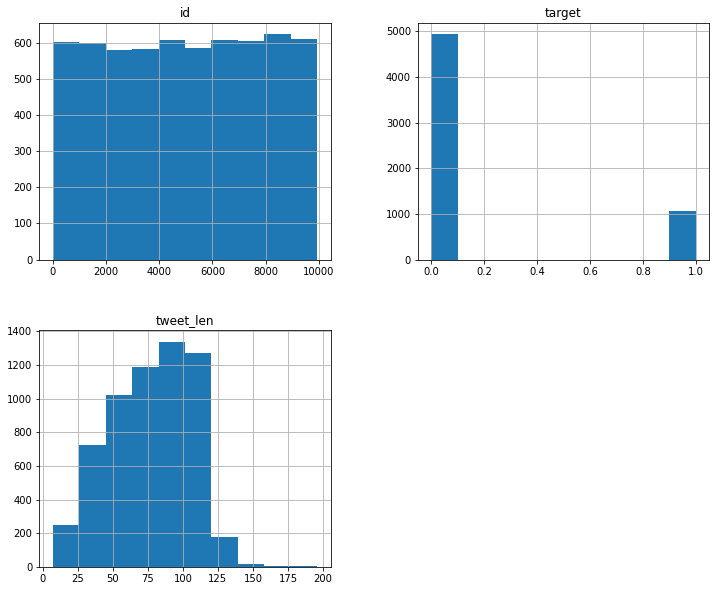

In [4]:
df_all['tweet_len'] = df_all.tweet.apply(len)
df_all.hist(figsize=(12,10))

In [5]:
df_all.tweet_len.describe()

count    6000.000000
mean       77.379333
std        29.294672
min         7.000000
25%        55.000000
50%        80.000000
75%       101.000000
max       196.000000
Name: tweet_len, dtype: float64

In [6]:
from sklearn.model_selection import train_test_split
df, df_holdout = train_test_split(df_all, test_size=0.15, shuffle=True, random_state=42, stratify=df_all.target.values)

In [7]:
!pip install transformers
!pip install datasets

     |████████████████████████████████| 2.8 MB 4.3 MB/s 
     |████████████████████████████████| 3.3 MB 22.7 MB/s 
     |████████████████████████████████| 52 kB 1.5 MB/s 
     |████████████████████████████████| 895 kB 53.3 MB/s 
     |████████████████████████████████| 636 kB 59.6 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 270 kB 4.2 MB/s 
     |████████████████████████████████| 1.3 MB 39.8 MB/s 
     |████████████████████████████████| 123 kB 53.4 MB/s 
     |████████████████████████████████| 243 kB 56.5 MB/s 
     |████████████████████████████████| 294 kB 54.8 MB/s 
     |████████████████████████████████| 142 kB 47.2 MB/s 


In [8]:
import os
import gc

from tqdm import tqdm
import json
from pprint import pprint

import math
import numpy as np

from transformers import AutoModel, AutoConfig, AutoTokenizer, BertForSequenceClassification, TrainingArguments, Trainer
import datasets

model_name = 'bert-base-multilingual-uncased'
bert_config = AutoConfig.from_pretrained(model_name)
bert_config.num_labels=2
bert_tokenizer = AutoTokenizer.from_pretrained(model_name)
bert_inputs = ["input_ids", "attention_mask", "token_type_ids"]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/872k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.72M [00:00<?, ?B/s]

In [9]:
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss, MSELoss
from transformers.modeling_outputs import SequenceClassifierOutput
class BalancedBertForSequenceClassification(BertForSequenceClassification):
    def __init__(self, config):
        super().__init__(config)
        self.weights = None

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        head_mask=None,
        inputs_embeds=None,
        labels=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
    ):
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        pooled_output = outputs[1]

        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        loss = None
        if labels is not None:
            if self.config.problem_type is None:
                if self.num_labels == 1:
                    self.config.problem_type = "regression"
                elif self.num_labels > 1 and (labels.dtype == torch.long or labels.dtype == torch.int):
                    self.config.problem_type = "single_label_classification"
                else:
                    self.config.problem_type = "multi_label_classification"

            if self.config.problem_type == "regression":
                loss_fct = MSELoss()
                if self.num_labels == 1:
                    loss = loss_fct(logits.squeeze(), labels.squeeze())
                else:
                    loss = loss_fct(logits, labels)
            elif self.config.problem_type == "single_label_classification":
                if self.weights is not None:
                  # Applying weights to account for imbalance
                  loss_fct = CrossEntropyLoss(weight=torch.from_numpy(weights).to(labels.device))
                else:
                  loss_fct = CrossEntropyLoss()
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            elif self.config.problem_type == "multi_label_classification":
                loss_fct = BCEWithLogitsLoss()
                loss = loss_fct(logits, labels)
        if not return_dict:
            output = (logits,) + outputs[2:]
            return ((loss,) + output) if loss is not None else output

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

In [10]:
import torch
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [11]:
accuracy_metric = datasets.load_metric("accuracy")
f1_metric = datasets.load_metric("f1")
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {
        **accuracy_metric.compute(predictions=predictions, references=labels),
        **f1_metric.compute(predictions=predictions, references=labels),
    }

Downloading:   0%|          | 0.00/1.42k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.96k [00:00<?, ?B/s]

In [15]:
!rm -rf ./urdu_trainer/*

In [ ]:
from sklearn.model_selection import KFold, StratifiedKFold
from transformers.trainer_utils import EvalPrediction
kfold = StratifiedKFold(n_splits=5, shuffle=False)
accuracy = []
f1 = []
for train_idx, test_idx in kfold.split(df, df.target.values):
  !rm -rf ./urdu_trainer/*
  inputs_train = { **bert_tokenizer(df.iloc[train_idx].tweet.values.tolist(),
                         return_tensors="pt",
                         truncation=True,
                         padding=True
                         ), "label": df.iloc[train_idx].target.values}
  X_train = datasets.Dataset.from_dict(inputs_train)
  inputs_test = {**bert_tokenizer(df.iloc[test_idx].tweet.values.tolist(),
                         return_tensors="pt",
                         truncation=True,
                         padding=True
                         ), "label": df.iloc[test_idx].target.values}
  X_test = datasets.Dataset.from_dict(inputs_test)
  training_args = TrainingArguments("urdu_trainer",
                                  evaluation_strategy="steps",
                                  load_best_model_at_end=True,
                                  metric_for_best_model="f1",
                                  logging_steps=8,
                                  eval_steps=8,
                                  save_steps=8,
                                  num_train_epochs=5,
                                  per_device_train_batch_size=32,
                                  per_device_eval_batch_size=32,
                                  save_total_limit=14)
  _, counts = np.unique(inputs_train["label"], return_counts=True)
  weights = np.array([1. / float(l) for l in counts], dtype=np.float32)
  weights /= np.sum(weights)
  print("weights:")
  print(type(weights))
  pprint(weights)
  bert = BalancedBertForSequenceClassification.from_pretrained(model_name, config=bert_config)
  bert.weights = weights
  bert.to(device)
  trainer = Trainer(
      model=bert,
      args=training_args,
      train_dataset=X_train,
      eval_dataset=X_test,
      compute_metrics=compute_metrics
  )
  
  trainer.train()

  with torch.no_grad():        
    outputs = bert(**{k: v.to(device) for k, v in inputs_test.items() if k != "label"}).logits.cpu().numpy()
    eval_pred = EvalPrediction(predictions=outputs, label_ids=np.array(inputs_test["label"]))
    metrics = compute_metrics(eval_pred)
    accuracy.append(metrics["accuracy"])
    f1.append(metrics["f1"])

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


weights:
<class 'numpy.ndarray'>
array([0.17843138, 0.8215686 ], dtype=float32)


loading weights file https://huggingface.co/bert-base-multilingual-uncased/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/37f730c9dc4fc13ab6bf412fdc0ad936241a39a70628c2d4a85a607ea775b865.a458b2dad7b293099dd815628e032e6c22519889d75f13d6f244dbe068525a56
Some weights of the model checkpoint at bert-base-multilingual-uncased were not used when initializing BalancedBertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BalancedBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected 

Step,Training Loss,Validation Loss,Accuracy,F1
8,0.705700,0.697370,0.182353,0.303840
16,0.698400,0.672698,0.591176,0.353488
24,0.679400,0.651069,0.496078,0.371638
32,0.647700,0.659958,0.549020,0.391534
40,0.708400,0.648453,0.782353,0.396739
48,0.646100,0.626539,0.729412,0.415254
56,0.676100,0.631697,0.770588,0.412060
64,0.657400,0.625182,0.620588,0.416290
72,0.644900,0.616836,0.761765,0.420048
80,0.648800,0.633823,0.450000,0.366102


***** Running Evaluation *****
  Num examples = 1020
  Batch size = 32
Saving model checkpoint to urdu_trainer/checkpoint-8
Configuration saved in urdu_trainer/checkpoint-8/config.json
Model weights saved in urdu_trainer/checkpoint-8/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1020
  Batch size = 32
Saving model checkpoint to urdu_trainer/checkpoint-16
Configuration saved in urdu_trainer/checkpoint-16/config.json
Model weights saved in urdu_trainer/checkpoint-16/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1020
  Batch size = 32
Saving model checkpoint to urdu_trainer/checkpoint-24
Configuration saved in urdu_trainer/checkpoint-24/config.json
Model weights saved in urdu_trainer/checkpoint-24/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1020
  Batch size = 32
Saving model checkpoint to urdu_trainer/checkpoint-32
Configuration saved in urdu_trainer/checkpoint-32/config.json
Model weights saved in urdu_trainer/checkpoint-32/p

weights:
<class 'numpy.ndarray'>
array([0.17843138, 0.8215686 ], dtype=float32)


loading weights file https://huggingface.co/bert-base-multilingual-uncased/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/37f730c9dc4fc13ab6bf412fdc0ad936241a39a70628c2d4a85a607ea775b865.a458b2dad7b293099dd815628e032e6c22519889d75f13d6f244dbe068525a56
Some weights of the model checkpoint at bert-base-multilingual-uncased were not used when initializing BalancedBertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BalancedBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected 

Step,Training Loss,Validation Loss,Accuracy,F1
8,0.708500,0.682312,0.756863,0.279070
16,0.693300,0.673276,0.428431,0.362842
24,0.682200,0.662821,0.774510,0.401042
32,0.655000,0.630194,0.772549,0.425743
40,0.726400,0.738855,0.822549,0.010929
48,0.700800,0.679156,0.186275,0.304858
56,0.694900,0.678803,0.813725,0.340278
64,0.674900,0.665196,0.522549,0.373230
72,0.650400,0.645595,0.533333,0.388175
80,0.658400,0.653838,0.821569,0.315789


***** Running Evaluation *****
  Num examples = 1020
  Batch size = 32
Saving model checkpoint to urdu_trainer/checkpoint-8
Configuration saved in urdu_trainer/checkpoint-8/config.json
Model weights saved in urdu_trainer/checkpoint-8/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1020
  Batch size = 32
Saving model checkpoint to urdu_trainer/checkpoint-16
Configuration saved in urdu_trainer/checkpoint-16/config.json
Model weights saved in urdu_trainer/checkpoint-16/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1020
  Batch size = 32
Saving model checkpoint to urdu_trainer/checkpoint-24
Configuration saved in urdu_trainer/checkpoint-24/config.json
Model weights saved in urdu_trainer/checkpoint-24/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1020
  Batch size = 32
Saving model checkpoint to urdu_trainer/checkpoint-32
Configuration saved in urdu_trainer/checkpoint-32/config.json
Model weights saved in urdu_trainer/checkpoint-32/p

weights:
<class 'numpy.ndarray'>
array([0.17843138, 0.8215686 ], dtype=float32)


loading weights file https://huggingface.co/bert-base-multilingual-uncased/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/37f730c9dc4fc13ab6bf412fdc0ad936241a39a70628c2d4a85a607ea775b865.a458b2dad7b293099dd815628e032e6c22519889d75f13d6f244dbe068525a56
Some weights of the model checkpoint at bert-base-multilingual-uncased were not used when initializing BalancedBertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BalancedBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected 

Step,Training Loss,Validation Loss,Accuracy,F1
8,0.720100,0.687477,0.379412,0.341311
16,0.680700,0.661018,0.688235,0.388462
24,0.667900,0.659795,0.656863,0.356618
32,0.689900,0.654585,0.807843,0.309859
40,0.634700,0.625491,0.728431,0.411890
48,0.681200,0.624140,0.806863,0.393846
56,0.676400,0.649740,0.817647,0.256000
64,0.651400,0.627450,0.738235,0.444906
72,0.603600,0.625995,0.699020,0.454707
80,0.648700,0.643355,0.821569,0.345324


***** Running Evaluation *****
  Num examples = 1020
  Batch size = 32
Saving model checkpoint to urdu_trainer/checkpoint-8
Configuration saved in urdu_trainer/checkpoint-8/config.json
Model weights saved in urdu_trainer/checkpoint-8/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1020
  Batch size = 32
Saving model checkpoint to urdu_trainer/checkpoint-16
Configuration saved in urdu_trainer/checkpoint-16/config.json
Model weights saved in urdu_trainer/checkpoint-16/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1020
  Batch size = 32
Saving model checkpoint to urdu_trainer/checkpoint-24
Configuration saved in urdu_trainer/checkpoint-24/config.json
Model weights saved in urdu_trainer/checkpoint-24/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1020
  Batch size = 32
Saving model checkpoint to urdu_trainer/checkpoint-32
Configuration saved in urdu_trainer/checkpoint-32/config.json
Model weights saved in urdu_trainer/checkpoint-32/p

Step,Training Loss,Validation Loss,Accuracy,F1
8,0.720100,0.687477,0.379412,0.341311
16,0.680700,0.661018,0.688235,0.388462
24,0.667900,0.659795,0.656863,0.356618
32,0.689900,0.654585,0.807843,0.309859
40,0.634700,0.625491,0.728431,0.411890
48,0.681200,0.624140,0.806863,0.393846
56,0.676400,0.649740,0.817647,0.256000
64,0.651400,0.627450,0.738235,0.444906
72,0.603600,0.625995,0.699020,0.454707
80,0.648700,0.643355,0.821569,0.345324


***** Running Evaluation *****
  Num examples = 1020
  Batch size = 32
Saving model checkpoint to urdu_trainer/checkpoint-552
Configuration saved in urdu_trainer/checkpoint-552/config.json
Model weights saved in urdu_trainer/checkpoint-552/pytorch_model.bin
Deleting older checkpoint [urdu_trainer/checkpoint-448] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1020
  Batch size = 32
Saving model checkpoint to urdu_trainer/checkpoint-560
Configuration saved in urdu_trainer/checkpoint-560/config.json
Model weights saved in urdu_trainer/checkpoint-560/pytorch_model.bin
Deleting older checkpoint [urdu_trainer/checkpoint-456] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1020
  Batch size = 32
Saving model checkpoint to urdu_trainer/checkpoint-568
Configuration saved in urdu_trainer/checkpoint-568/config.json
Model weights saved in urdu_trainer/checkpoint-568/pytorch_model.bin
Deleting older checkpoint [urdu_trainer/checkpoint-464] 

weights:
<class 'numpy.ndarray'>
array([0.17843138, 0.8215686 ], dtype=float32)


loading weights file https://huggingface.co/bert-base-multilingual-uncased/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/37f730c9dc4fc13ab6bf412fdc0ad936241a39a70628c2d4a85a607ea775b865.a458b2dad7b293099dd815628e032e6c22519889d75f13d6f244dbe068525a56
Some weights of the model checkpoint at bert-base-multilingual-uncased were not used when initializing BalancedBertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BalancedBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected 

Step,Training Loss,Validation Loss,Accuracy,F1
8,0.704800,0.682656,0.449020,0.340376
16,0.676500,0.675411,0.812745,0.239044
24,0.702100,0.670581,0.787255,0.293160
32,0.679700,0.654327,0.776471,0.325444
40,0.598900,0.650054,0.712745,0.395876
48,0.711500,0.653800,0.584314,0.365269
56,0.678000,0.665027,0.821569,0.320896
64,0.661600,0.685618,0.350980,0.335341
72,0.619900,0.701525,0.659804,0.370236
80,0.691900,0.635015,0.776471,0.412371


***** Running Evaluation *****
  Num examples = 1020
  Batch size = 32
Saving model checkpoint to urdu_trainer/checkpoint-8
Configuration saved in urdu_trainer/checkpoint-8/config.json
Model weights saved in urdu_trainer/checkpoint-8/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1020
  Batch size = 32
Saving model checkpoint to urdu_trainer/checkpoint-16
Configuration saved in urdu_trainer/checkpoint-16/config.json
Model weights saved in urdu_trainer/checkpoint-16/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1020
  Batch size = 32
Saving model checkpoint to urdu_trainer/checkpoint-24
Configuration saved in urdu_trainer/checkpoint-24/config.json
Model weights saved in urdu_trainer/checkpoint-24/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1020
  Batch size = 32
Saving model checkpoint to urdu_trainer/checkpoint-32
Configuration saved in urdu_trainer/checkpoint-32/config.json
Model weights saved in urdu_trainer/checkpoint-32/p

In [ ]:
# CV never withstands colab time limits
f"accuracy: {(np.mean(accuracy), np.std(accuracy))} \n f1: {(np.mean(f1), np.std(f1))}"

In [ ]:
from transformers.trainer_utils import EvalPrediction
!rm -rf ./urdu_trainer/*
inputs_all_train = { **bert_tokenizer(df.tweet.values.tolist(),
                        return_tensors="pt",
                        truncation=True,
                        
                        padding=True
                        ), "label": df.target.values}
X_all_train = datasets.Dataset.from_dict(inputs_all_train)
inputs_holdout = {**bert_tokenizer(df_holdout.tweet.values.tolist(),
                        return_tensors="pt",
                        truncation=True,
                        padding=True
                        ), "label": df_holdout.target.values}
X_holdout = datasets.Dataset.from_dict(inputs_holdout)

In [ ]:
training_args_final = TrainingArguments("urdu_trainer",
                                  evaluation_strategy="steps",
                                  load_best_model_at_end=True,
                                  metric_for_best_model="f1",
                                  logging_steps=8,
                                  eval_steps=8,
                                  save_steps=8,
                                  num_train_epochs=5,
                                  per_device_train_batch_size=32,
                                  per_device_eval_batch_size=32,
                                  save_total_limit=15)
_, counts = np.unique(inputs_all_train["label"], return_counts=True)
weights = np.array([1. / float(l) for l in counts], dtype=np.float32)
weights /= np.sum(weights)
print("weights:")
print(type(weights))
pprint(weights)
bert_final = BalancedBertForSequenceClassification.from_pretrained(model_name, config=bert_config)
bert_final.weights = weights
bert_final.to(device)
trainer_final = Trainer(
    model=bert_final,
    args=training_args_final,
    train_dataset=X_all_train,
    eval_dataset=X_holdout,
    compute_metrics=compute_metrics
)

weights:
<class 'numpy.ndarray'>
array([0.17843136, 0.8215686 ], dtype=float32)


Downloading:   0%|          | 0.00/672M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-multilingual-uncased were not used when initializing BalancedBertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BalancedBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BalancedBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BalancedBertForSequenceClassification were

In [ ]:
trainer_final.train()

***** Running training *****
  Num examples = 5100
  Num Epochs = 5
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 800


Step,Training Loss,Validation Loss,Accuracy,F1
8,0.696000,0.695651,0.821111,0.000000
16,0.740400,0.694865,0.821111,0.000000
24,0.704200,0.690818,0.821111,0.000000
32,0.751600,0.700906,0.821111,0.000000
40,0.696000,0.693729,0.178889,0.303487
48,0.712000,0.703832,0.178889,0.303487
56,0.694400,0.698155,0.821111,0.000000
64,0.674200,0.696248,0.821111,0.000000
72,0.690400,0.684462,0.821111,0.012270
80,0.692000,0.679984,0.341111,0.334456


***** Running Evaluation *****
  Num examples = 900
  Batch size = 32
Saving model checkpoint to urdu_trainer/checkpoint-8
Configuration saved in urdu_trainer/checkpoint-8/config.json
Model weights saved in urdu_trainer/checkpoint-8/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 900
  Batch size = 32
Saving model checkpoint to urdu_trainer/checkpoint-16
Configuration saved in urdu_trainer/checkpoint-16/config.json
Model weights saved in urdu_trainer/checkpoint-16/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 900
  Batch size = 32
Saving model checkpoint to urdu_trainer/checkpoint-24
Configuration saved in urdu_trainer/checkpoint-24/config.json
Model weights saved in urdu_trainer/checkpoint-24/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 900
  Batch size = 32
Saving model checkpoint to urdu_trainer/checkpoint-32
Configuration saved in urdu_trainer/checkpoint-32/config.json
Model weights saved in urdu_trainer/checkpoint-32/pytor

Step,Training Loss,Validation Loss,Accuracy,F1
8,0.696000,0.695651,0.821111,0.000000
16,0.740400,0.694865,0.821111,0.000000
24,0.704200,0.690818,0.821111,0.000000
32,0.751600,0.700906,0.821111,0.000000
40,0.696000,0.693729,0.178889,0.303487
48,0.712000,0.703832,0.178889,0.303487
56,0.694400,0.698155,0.821111,0.000000
64,0.674200,0.696248,0.821111,0.000000
72,0.690400,0.684462,0.821111,0.012270
80,0.692000,0.679984,0.341111,0.334456


***** Running Evaluation *****
  Num examples = 900
  Batch size = 32
Saving model checkpoint to urdu_trainer/checkpoint-552
Configuration saved in urdu_trainer/checkpoint-552/config.json
Model weights saved in urdu_trainer/checkpoint-552/pytorch_model.bin
Deleting older checkpoint [urdu_trainer/checkpoint-432] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 900
  Batch size = 32
Saving model checkpoint to urdu_trainer/checkpoint-560
Configuration saved in urdu_trainer/checkpoint-560/config.json
Model weights saved in urdu_trainer/checkpoint-560/pytorch_model.bin
Deleting older checkpoint [urdu_trainer/checkpoint-440] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 900
  Batch size = 32
Saving model checkpoint to urdu_trainer/checkpoint-568
Configuration saved in urdu_trainer/checkpoint-568/config.json
Model weights saved in urdu_trainer/checkpoint-568/pytorch_model.bin
Deleting older checkpoint [urdu_trainer/checkpoint-448] due

TrainOutput(global_step=800, training_loss=0.4825073906779289, metrics={'train_runtime': 4426.0117, 'train_samples_per_second': 5.761, 'train_steps_per_second': 0.181, 'total_flos': 1048333111200000.0, 'train_loss': 0.4825073906779289, 'epoch': 5.0})

In [ ]:
with torch.no_grad():
  outputs = bert_final(**{k: v.to(device) for k, v in inputs_holdout.items() if k != "label"}).logits.cpu().numpy()
  eval_pred = EvalPrediction(predictions=outputs, label_ids=np.array(inputs_holdout["label"]))
  metrics_final = compute_metrics(eval_pred)
  print(f"accuracy final: {metrics_final['accuracy']} \nf1 final\t: {metrics_final['f1']}")

accuracy final: 0.7608333333333334 
f1 final	: 0.48841354723707664


In [ ]:
df_test_final = pd.read_csv('/content/drive/MyDrive/urdu/th/test.csv')

In [ ]:
df_test_final = df_test_final.tweet.values.tolist()
inputs_test_final = {**bert_tokenizer(df_test_final,
                        return_tensors="pt",
                        truncation=True,
                        padding=True
                        )}
with torch.no_grad():        
  outputs = bert_final(**{k: v.to(device) for k, v in inputs_test_final.items()}).logits.cpu().numpy()

In [ ]:
predictions = np.argmax(outputs, axis=-1)

In [ ]:
score = softmax(outputs, axis=-1)

In [ ]:
df_test_final['target'] = predictions
df_test_final['score'] = score[:, 1]
df_test_final

In [ ]:
df_test_final[['id', 'target', 'score']].to_csv(f'/content/drive/MyDrive/urdu/th/submission.csv', index=False)